## Document Search : Comorbidities

In [17]:
import sys
import json
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from collections import Counter

#### Comorbidities dataset

In [18]:
with open("input/comorb-major.json",'r')as fin:
    comorb = json.load(fin)

#### Upload Covid-19 Corpus

In [19]:
with open('data/t2pmid-covid.json','r')as f2:
    t2pmid = json.load(f2)

In [20]:
tdf = pd.DataFrame(t2pmid)
tdf.head()

,pmid,mesh,date,title,abstract
0,32071063,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '18', ...",Coronavirus covid-19 has killed more people th...,
1,32072794,[],"{'Year': '2020', 'Month': '02', 'Day': '19', '...",[Cluster investigation Technical Guidelines fo...,
2,32086235,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '21', ...",Rules on isolation rooms for suspected covid-1...,
3,32087216,"['Betacoronavirus', 'genetics', 'pathogenicity...","{'Year': '2020', 'Month': '04', 'Day': '', 'Se...",A Novel Coronavirus (COVID-19) Outbreak: A Cal...,
4,32093043,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '19', ...",Risk Assessment of Novel Coronavirus COVID-19 ...,we developed a computational tool to assess th...


In [21]:
tdf.shape

(80732, 5)

In [22]:
covid_pmids = list(set(tdf['pmid']))
len(covid_pmids)

80732

#### Count Documents for Comorbidities (Major)

In [23]:
n2count = {}
n2pmid = {}
n2pmidset = {}
allpmids = []
for name in comorb:
    n2count[name] = 0
    n2pmid[name] = 0
    n2pmidset[name] = []
    
text = ""            
for pmid,title,abstract,mesh in  zip(tdf['pmid'],tdf['title'],tdf['abstract'],tdf['mesh']):
    
        
    for name, entities in comorb.items():
        tn = 0
        for entity in entities:
            
            n_title = title.count(entity)
            tn = tn+n_title
            
            if len(abstract)>1:
                text = abstract
                
            n_abs = text.count(entity)
            tn = tn+n_abs
            
            n_mesh = mesh.count(entity)
            tn = tn+n_mesh
            
        n2count[name] = n2count[name] + tn
        
        if tn>0:
            n2pmid[name] = n2pmid[name] + 1
            n2pmidset[name].append(pmid)
            allpmids.append(pmid)
                

In [24]:
with open('result/name2pmidset-comorb-major.json','w')as f3:
    json.dump(n2pmidset,f3)

In [25]:
len(set(allpmids))

8923

#### Counting Covid-19 Documents for individual Comorbidities (Major)

In [13]:
Data = []
for name, count in n2pmid.items():
    Data.append({"Name":name,"Text Datasets": count})
    
df = pd.DataFrame(Data)
df = df.set_index("Name")
df.to_csv("result/comorb-count-major.csv")

In [14]:
df

,Text Datasets
Name,
pregnancy,1289
transplantation,1411
smoking,699
cardiovascular diseases,1240
obesity,1670
"pulmonary disease, chronic obstructive",1127
neoplasms,1561
"diabetes mellitus, type 2",823
kidney diseases,762


#### Co-occurance of Covid Symptoms and Comorb

In [85]:
with open('result/name2pmidset-covid.json','r')as f4:
    n2pmidset_covid = json.load(f4)

In [86]:
Data = []
allpmid = []
for name1, pmids1 in n2pmidset_covid.items():
    data = {}
    data.update({"covid symptoms" : name1})
                
    for name2, pmids2 in n2pmidset.items():
        ints = set(pmids1).intersection(set(pmids2))
        
        for item in list(ints):
            allpmid.append(item)
            
        data.update({name2:len(set(ints))})
    
    Data.append(data)
        

In [87]:
len(list(set(allpmid)))

1207

In [88]:
cdf = pd.DataFrame(Data)
#cdf.to_csv("covid-comorb-major.csv")

In [89]:
cdf = cdf.set_index("covid symptoms")

In [90]:
tcdf = cdf.T.sort_index()
tcdf

covid symptoms,fever,chills,cough,fatigue,shortness of breath,sore throat,rhinorrhea,diarrhea,vomiting,nausea,headache,myalgia,ageusia,confusion,chest pain,anosmia,cyanosis,hypersomnia
cardiovascular diseases,85,7,53,20,89,6,0,9,7,7,8,10,3,2,20,8,1,0
"diabetes mellitus, type 2",130,5,118,21,103,18,4,19,7,7,15,16,5,0,17,17,0,0
down syndrome,2,0,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
kidney diseases,104,3,79,21,73,11,1,13,8,6,9,7,1,0,3,11,0,0
neoplasms,62,10,22,15,28,0,2,5,11,6,13,3,4,3,0,6,0,0
obesity,137,14,91,18,66,5,2,14,5,4,11,13,8,4,14,19,0,0
pregnancy,159,13,124,24,74,10,3,18,23,14,25,36,1,0,5,12,0,0
"pulmonary disease, chronic obstructive",112,4,99,37,111,15,5,15,10,9,24,21,3,10,9,18,0,0
smoking,55,3,42,13,41,4,3,9,3,5,11,9,2,3,8,11,0,0
transplantation,156,13,83,21,54,5,6,31,10,8,7,10,2,3,3,8,0,0


In [92]:
tcdf.to_csv("result/covid-comorb-major.csv")

In [93]:
cdf.sum()

pregnancy                                 541
transplantation                           420
smoking                                   222
cardiovascular diseases                   335
obesity                                   425
pulmonary disease, chronic obstructive    502
neoplasms                                 190
diabetes mellitus, type 2                 502
kidney diseases                           350
down syndrome                               7
dtype: int64

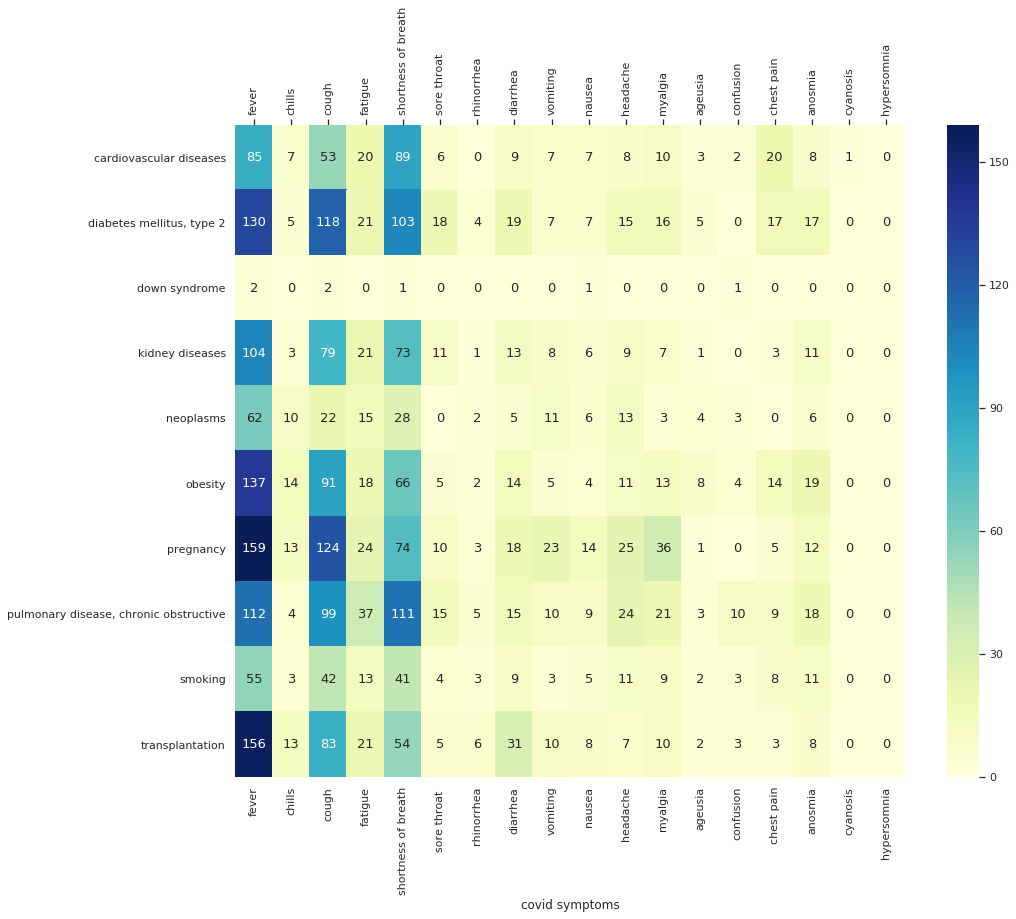

In [94]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

matplotlib.rcParams.update({'font.size': 13})
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

plt.figure(figsize = [15,12])

#idf = newdf.set_index("name")
sns.heatmap(tcdf, annot=True, cmap = "YlGnBu", fmt = "d")


plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

plt.savefig("plots/heatmap_comorb_major.png")